# Evaluating Multi-Modal RAG

In [ ]:
# %pip install llama_index ftfy regex tqdm -q
# %pip install git+https://github.com/openai/CLIP.git -q
# %pip install torch torchvision -q
# %pip install matplotlib scikit-image -q
# %pip install -U qdrant_client -q

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

## Use Case: Spelling In ASL

Load in our data

In [ ]:
from llama_index.multi_modal_llms.generic_utils import (
    load_image_urls,
)
from llama_index import SimpleDirectoryReader

image_path = "/Users/nerdai/Datasets/Images/asl-labelled"
image_documents = SimpleDirectoryReader(image_path).load_data()

### Text descriptions of each ASL manual alphabet

Reference: All descriptions with the exception of the one for "SPACE" was extracted from the website listed below.
https://www.deafblind.com/asl.html

They have since been stored in the json filed `asl_text_descriptions.json`.

In [ ]:
import json

# human curated descriptions
with open("asl_text_descriptions.json") as json_file:
    asl_text_descriptions = json.load(json_file)

Create the asl vector index

In [ ]:
from llama_index.schema import Document, ImageNode, TextNode, ImageDocument

LETTERS = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "SPACE",
]

text_format_str = "To sign {letter} in ASL: {desc}."
text_documents = [
    Document(
        text=text_format_str.format(
            letter=letter, desc=asl_text_descriptions[letter]
        )
    )
    for letter in LETTERS
]

### GPT-4V Generated Text Descriptions of Every Image

In [ ]:
# from llama_index.multi_modal_llms.openai import OpenAIMultiModal
# import tqdm

# # define our lmm
# openai_mm_llm = OpenAIMultiModal(
#     model="gpt-4-vision-preview", max_new_tokens=300
# )

# # make a new copy since we want to store text in its attribute
# image_with_text_documents = SimpleDirectoryReader(image_path).load_data()

# # get text desc and save to text attr
# for img_doc in tqdm.tqdm(image_with_text_documents):
#     response = openai_mm_llm.complete(
#         prompt="Describe the images as an alternative text",
#         image_documents=[img_doc],
#     )
#     img_doc.text = response.text

# # save so don't have to incur expensive gpt-4v calls again
# desc_jsonl = [json.loads(img_doc.to_json()) for img_doc in image_with_text_documents]
# with open("image_descriptions.json", "w") as f:
#     json.dump(desc_jsonl, f)

In [ ]:
# load up previously saved image descriptions
with open("image_descriptions.json") as f:
    image_descriptions = json.load(f)

image_with_text_documents = [
    ImageDocument.from_dict(el) for el in image_descriptions
]

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.node_parser import SimpleNodeParser

node_parser = SimpleNodeParser.from_defaults()
image_nodes = node_parser.get_nodes_from_documents(image_documents)
image_with_text_nodes = node_parser.get_nodes_from_documents(
    image_with_text_documents
)
text_nodes = node_parser.get_nodes_from_documents(text_documents)

asl_index = MultiModalVectorStoreIndex(image_nodes + text_nodes)

asl_text_desc_index = MultiModalVectorStoreIndex(
    image_with_text_nodes + text_nodes
)

## Build Our Multi-Modal RAG System

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.multi_modal_llms.replicate_multi_modal import (
    ReplicateMultiModal,
)
from llama_index.prompts import PromptTemplate

# define our QA prompt template
qa_tmpl_str = (
    "Images of hand gestures for ASL are provided.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "If the images provided cannot help in answering the query\n"
    "then respond that you are unable to answer the query. Otherwise,\n"
    "using only the context provided, and not prior knowledge,\n"
    "provide an answer to the query."
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

# define our lmms
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", max_new_tokens=300
)

llava_mm_llm = ReplicateMultiModal(
    model="yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
    max_new_tokens=300,
)

# define our RAG query engines
rag_engines = {
    "mm_clip_gpt4v": asl_index.as_query_engine(
        multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
    ),
    "mm_clip_llava": asl_index.as_query_engine(
        multi_modal_llm=llava_mm_llm, text_qa_template=qa_tmpl
    ),
    "mm_text_desc_gpt4v": asl_text_desc_index.as_query_engine(
        multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
    ),
    "mm_text_desc_llava": asl_text_desc_index.as_query_engine(
        multi_modal_llm=llava_mm_llm, text_qa_template=qa_tmpl
    ),
}

#### Test drive our Multi-modal RAG

In [ ]:
query_str = "How can I sign a S?"
response = rag_engines["mm_clip_llava"].query(query_str)

Query: How can I sign a S?
Retrieved Images:



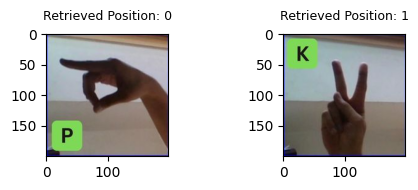

Response: To sign S in ASL, you should make a clenched fist with all of your fingers folded tightly into your palm. Your thumb should be positioned across your index and middle fingers.



In [ ]:
from llama_index.response.notebook_utils import (
    display_query_and_multimodal_response,
)

display_query_and_multimodal_response(query_str, response)

### Retriever Evaluation

In [ ]:
# use as retriever
clip_retriever = asl_index.as_retriever(image_similarity_top_k=2)

# use as retriever
text_desc_retriever = asl_text_desc_index.as_retriever(
    image_similarity_top_k=2
)

#### Visual

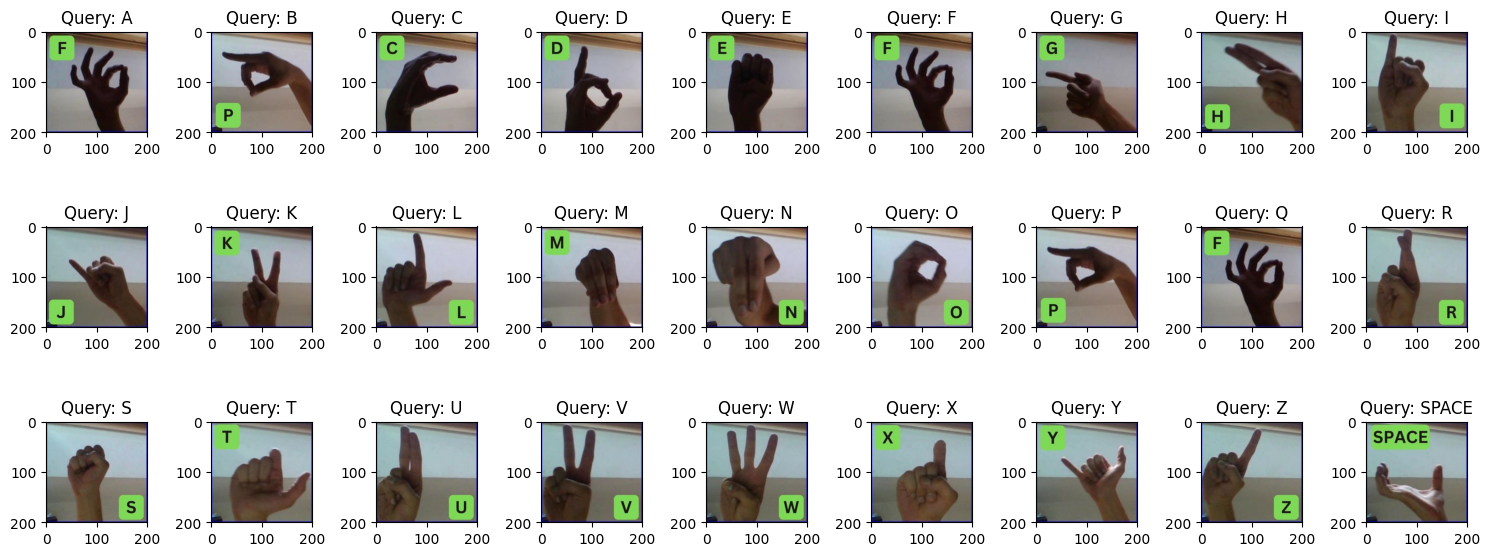

In [ ]:
f, axarr = plt.subplots(3, 9)
f.set_figheight(6)
f.set_figwidth(15)
ix = 0
for jx, letter in enumerate(LETTERS):
    retrieval_results = text_desc_retriever.retrieve(
        f"How can I sign {letter}?"
    )
    image_node = None
    text_node = None
    for r in retrieval_results:
        if isinstance(r.node, TextNode):
            text_node = r
        if isinstance(r.node, ImageNode):
            image_node = r
            break

    img_path = image_node.node.image_path
    image = Image.open(img_path).convert("RGB")
    axarr[int(jx / 9), jx % 9].imshow(image)
    axarr[int(jx / 9), jx % 9].set_title(f"Query: {letter}")

plt.setp(axarr, xticks=[0, 100, 200], yticks=[0, 100, 200])
f.tight_layout()
plt.show()

#### Quantitative: Hit Rate and MRR 

In [ ]:
from llama_index.evaluation import MultiModalRetrieverEvaluator

clip_retriever_evaluator = MultiModalRetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=clip_retriever
)

text_desc_retriever_evaluator = MultiModalRetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=text_desc_retriever
)

In [ ]:
# create the qa dataset
import uuid
import re
from llama_index.evaluation import LabelledQADataset

query_str = "How can I sign a {symbol}?."

# labelled dataset for image retrieval
reg_ex = r"(?:([A-Z]+).jpg)"
queries = {}
relevant_docs = {}
for img_node in image_nodes:
    match = re.search(reg_ex, img_node.metadata["file_path"])
    if match:
        query = query_str.format(symbol=match.group(1))
        id_ = str(uuid.uuid4())
        queries[id_] = query
        relevant_docs[id_] = [img_node.id_]

qa_dataset_image = LabelledQADataset(
    queries=queries, relevant_docs=relevant_docs, corpus={}, mode="image"
)

# labelled dataset for text retrieval
reg_ex = r"(?:To sign ([A-Z]+) in ASL:)"
queries = {}
relevant_docs = {}
for text_node in text_nodes:
    match = re.search(reg_ex, text_node.text)
    if match:
        query = query_str.format(symbol=match.group(1))
        id_ = str(uuid.uuid4())
        queries[id_] = query
        relevant_docs[id_] = [text_node.id_]

qa_dataset_text = LabelledQADataset(
    queries=queries,
    relevant_docs=relevant_docs,
    corpus={},
)

# labelled dataset for text-desc retrieval
reg_ex = r"(?:([A-Z]+).jpg)"
queries = {}
relevant_docs = {}
for img_node in image_with_text_nodes:
    match = re.search(reg_ex, img_node.metadata["file_path"])
    if match:
        query = query_str.format(symbol=match.group(1))
        id_ = str(uuid.uuid4())
        queries[id_] = query
        relevant_docs[id_] = [img_node.id_]

qa_dataset_text_desc = LabelledQADataset(
    queries=queries, relevant_docs=relevant_docs, corpus={}, mode="image"
)

In [ ]:
eval_results_image = await clip_retriever_evaluator.aevaluate_dataset(
    qa_dataset_image
)
eval_results_text = await clip_retriever_evaluator.aevaluate_dataset(
    qa_dataset_text
)
eval_results_text_desc = await text_desc_retriever_evaluator.aevaluate_dataset(
    qa_dataset_text_desc
)

In [ ]:
from llama_index.evaluation.notebook_utils import get_retrieval_results_df

get_retrieval_results_df(
    names=["asl_index-image", "asl_index-text", "asl_text_desc_index"],
    results_arr=[
        eval_results_image,
        eval_results_text,
        eval_results_text_desc,
    ],
)

,retrievers,hit_rate,mrr
0,asl_index-image,0.814815,0.814815
1,asl_index-text,1.000000,1.000000
2,asl_text_desc_index,0.925926,0.925926


### Generation Evaluation

Three RAG systems under consideration:
- `mm_clip_gpt4v` = Multi-Modal RAG with CLIP image encoder, lmm = GPT-4V using both `image_documents` and `text_documents`
- `mm_clip_llava` = Multi-Modal RAG with CLIP image encoder, lmm = LLaVA using both `image_documents` and `text_documents`
- `mm_text_desc_gpt4v` = Multi-Modal RAG with text-desc + ada image encoder, lmm = GPT-4V using both `image_documents` and `text_documents`
- `mm_text_desc_llava` = Multi-Modal RAG with text-desc + ada image encoder, lmm = LLaVA using both `image_documents` and `text_documents`

In [ ]:
# references for our answers
# sourced from https://www.signingtime.com/dictionary/category/letters/
with open("human_responses.json") as json_file:
    human_answers = json.load(json_file)

#### Generate Responses To ALL Queries For Each System

In [ ]:
subset_rag_engines = {k: v for k, v in rag_engines.items() if "gpt4v" in k}
subset_rag_engines

{'mm_clip_gpt4v': <llama_index.query_engine.multi_modal.SimpleMultiModalQueryEngine at 0x172af3a30>,
 'mm_text_desc_gpt4v': <llama_index.query_engine.multi_modal.SimpleMultiModalQueryEngine at 0x17741ae30>}

In [ ]:
import time
import tqdm

for data_entry in tqdm.tqdm(response_data[16:17]):
    query = data_entry["query"]
    responses = {}
    for name, engine in rag_engines.items():
        this_response = {}
        result = engine.query(query)
        this_response["response"] = result.response

        sources = {}
        source_image_nodes = []
        source_text_nodes = []

        # image sources
        source_image_nodes = [
            score_img_node.node.metadata["file_path"]
            for score_img_node in result.metadata["image_nodes"]
        ]

        # text sources
        source_text_nodes = [
            score_text_node.node.text
            for score_text_node in result.metadata["text_nodes"]
        ]

        sources["images"] = source_image_nodes
        sources["texts"] = source_text_nodes
        this_response["sources"] = sources

        responses[name] = this_response
    data_entry["responses"].update(responses)
    response_data.append(data_entry)
    # time.sleep(2)

# save expensive gpt-4v responses
with open("expensive_response_data.json", "w") as json_file:
    json.dump(response_data, json_file)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.49s/it]


In [ ]:
# import time
# import tqdm
# query_str = "How can I sign a {symbol}?."

# response_data = []
# for letter in tqdm.tqdm(LETTERS):
#     data_entry = {}
#     query = query_str.format(symbol=letter)
#     data_entry["query"] = query

#     responses = {}
#     for name, engine in subset_rag_engines.items():
#         this_response = {}
#         result = engine.query(query)
#         this_response['response'] = result.response

#         sources = {}
#         source_image_nodes = []
#         source_text_nodes = []

#         # image sources
#         source_image_nodes = [score_img_node.node.metadata["file_path"]
#                                         for score_img_node in result.metadata["image_nodes"]
#                                    ]

#         # text sources
#         source_text_nodes = [score_text_node.node.text
#                                         for score_text_node in result.metadata["text_nodes"]
#                                    ]

#         sources['images'] = source_image_nodes
#         sources['texts'] = source_text_nodes
#         this_response['sources'] = sources

#         responses[name] = this_response
#     data_entry['responses'] = responses
#     response_data.append(data_entry)
#     # time.sleep(2)

# # save expensive gpt-4v responses
# with open('expensive_response_data.json', 'w') as json_file:
#     json.dump(response_data, json_file)

In [ ]:
# # load previously generated responses
# with open('expensive_response_data.json') as json_file:
#     response_data = json.load(json_file)

### LLM-As-A-Judge: Correctness

In [ ]:
from llama_index import ServiceContext
from llama_index.llms import OpenAI
from llama_index.evaluation import (
    CorrectnessEvaluator,
    PairwiseComparisonEvaluator,
)
import os

gpt_4_context = ServiceContext.from_defaults(
    llm=OpenAI(
        temperature=0, model="gpt-4", api_key=os.getenv("OPENAI_API_KEY_ORG")
    ),
)

gpt4_judge = CorrectnessEvaluator(service_context=gpt_4_context)

In [ ]:
import tqdm
import re

for data_entry in tqdm.tqdm(response_data[:2]):
    reg_ex = r"(?:How can I sign a ([A-Z]+)?)"
    match = re.search(reg_ex, data_entry["query"])
    if match:
        letter = match.group(1)
        for rag, rdata in data_entry["responses"].items():
            if "image" in rag:
                text_context = ""
            else:
                text_context = rdata["sources"]["texts"][0]
            score = 0

            # check if retrieved images do not match the letter
            if not any(
                [f"{letter}.jpg" in el for el in rdata["sources"]["images"]]
            ):
                reference_answer = "Sorry, the images provided are not relevant to query, and thus I cannot provide an answer."
            else:
                reference_answer = human_answers[letter]

            eval_result = await gpt4_judge.aevaluate(
                query=data_entry["query"],
                response=rdata["response"],
                context=text_context,
                reference=reference_answer,
            )
            # take average and update eval_result... keep everythin else
            rdata["evaluations"] = [eval_result]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.93s/it]


In [ ]:
names = []
evals = []
for data_entry in response_data[:2]:
    for name, response in data_entry["responses"].items():
        names.append(name)
        evals.append(response["evaluations"][0])

In [ ]:
from llama_index.evaluation.notebook_utils import (
    get_eval_results_df,
    df_make_pretty,
)

result_df, mean_scores = get_eval_results_df(
    names, evals, metric="correctness"
)

In [ ]:
mean_scores

rag,clip_image_only_gpt4v,clip_image_only_llava,mm_clip_gpt4v,mm_clip_llava,mm_text_desc_gpt4v,mm_text_desc_llava
mean_correctness_score,4.5,1.5,4.75,2.75,3.75,2.0


In [ ]:
df_make_pretty(result_df[:5])

,rag,query,scores,feedbacks
0,mm_text_desc_gpt4v,How can I sign a A?.,3.000000,The generated answer is relevant to the user query but it lacks the detailed explanation provided in the reference answer. It also does not mention the important point about the thumb's position which differentiates the sign for 'A' from 'S'.
1,mm_text_desc_llava,How can I sign a A?.,2.000000,"The generated answer is relevant to the user query, but it contains mistakes. The description of the sign for 'A' is incorrect, as it does not match the reference answer. The user is instructed to form an 'F' hand gesture first, which is not part of the correct process."
2,mm_clip_gpt4v,How can I sign a A?.,5.000000,"The generated answer is completely relevant and correct, matching the reference answer in meaning and intent."
3,mm_clip_llava,How can I sign a A?.,1.000000,"The generated answer is not relevant to the user query. The user query seems to be incomplete or unclear, and the chatbot's response does not address this issue. Instead, it provides information on how to sign the letter 'A' in ASL, which may not be what the user was asking for."
4,clip_image_only_llava,How can I sign a A?.,1.000000,"The generated answer is not relevant to the user query. The user query is not clear and the reference answer indicates that there is not enough information to provide an answer. The generated answer, however, provides a detailed explanation on how to sign ""a"" in American Sign Language, which is not related to the user's query."
